In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize
plt.style.use('dark_background')
import ipywidgets as widgets

# Experimental design 

In [ ]:
#@title Create experiment
# Set number of trials (must be divisible by 10 and 4) 
trials = 200

# Experiment data frame 
EXP = pd.DataFrame(data = np.zeros(shape=[trials,3]), 
                   columns= ['stimuli', 'direction', 'response'])

# stimuli values
stimuli = np.array([1,2,3,4,5,6,7,8,9,10]); 
direction = np.array([1, 2, 3, 4]) # left, right, up, down

# simulate stimulus schedule 
cols = int(trials/10)
stimuli_present = np.zeros(shape=[10,cols])
for i in np.arange(0,cols):
  stimuli_present[:,i] = np.random.choice(stimuli, size=10, replace=False)

# add stimuli 
EXP['stimuli'] = np.matrix.flatten(stimuli_present, 'C')

# simulate direction schedule
cols = int(trials/4)
direction_present = np.zeros(shape=[4,cols])
for i in np.arange(0,cols):
  direction_present[:,i] = np.random.choice(direction, size=4, replace=False)

# add direction 
EXP['direction'] = np.matrix.flatten(direction_present, 'C')

# simulate appropriate responses 
response_schedule = np.zeros(shape=[trials,1])
for i in np.arange(0,trials):
  D = EXP['direction'][i]
  stim = EXP['stimuli'][i]
  if (stim == 1) or (stim == 2) or (stim == 3):

    w = np.array([0.25, 0.25, 0.25, 0.25]) # weights

  elif (stim == 4):

    w = np.array([0.183, 0.183, 0.183, 0.183]) # weights
    x = np.where(direction == D)
    w[x[0][0]] = (1 - 0.183*3)

  elif (stim == 5):

    w = np.array([0.15, 0.15, 0.15, 0.15]) # weights
    x = np.where(direction == D)
    w[x[0][0]] = 0.55

  elif (stim == 6):

    w = np.array([0.116, 0.116, 0.116, 0.116]) # weights
    x = np.where(direction == D)
    w[x[0][0]] = (1 - (0.116*3))

  elif (stim == 7):

    w = np.array([0.03, 0.03, 0.03, 0.03]) # weights
    x = np.where(direction == D)
    w[x[0][0]] = (1 - (0.03*3))

  elif (stim == 8) or (stim == 9) or (stim == 10):

    w = np.array([0.00167, 0.00167, 0.00167, 0.00167]) # weights
    x = np.where(direction == D)
    w[x[0][0]] = (1 - (0.00167*3))

  # Put in vector 
  response_schedule[i] = np.random.choice(direction, size=1, p=w)

# add response 
EXP['response'] = response_schedule

# Visualize Experiment

In [ ]:
EXP.head(10)

,stimuli,direction,response
0,3.0,3.0,3.0
1,4.0,4.0,2.0
2,5.0,3.0,4.0
3,10.0,1.0,1.0
4,6.0,4.0,4.0
5,9.0,4.0,4.0
6,3.0,2.0,4.0
7,4.0,4.0,1.0
8,9.0,4.0,4.0
9,4.0,1.0,2.0


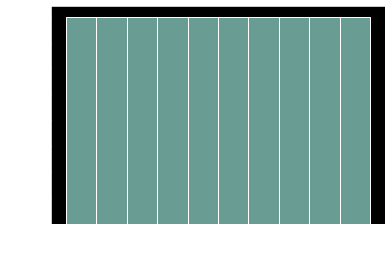

In [ ]:
# Stimulus 
plt.figure()
sns.histplot(x='stimuli', data = EXP, bins = [1,2,3,4,5,6,7,8,9,10,11])
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10])
plt.show()

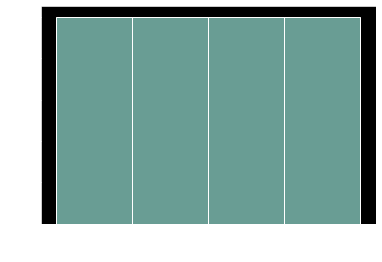

In [ ]:
# Directions
plt.figure()
sns.histplot(x='direction', data=EXP, bins=[1,2,3,4,5])
plt.xticks(ticks=[1,2,3,4])
plt.show()

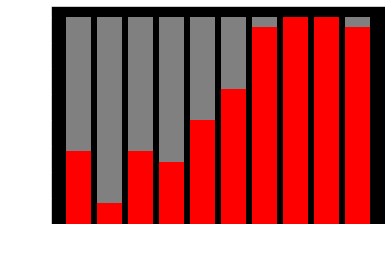

In [ ]:
# Stimulus x (Correct & Wrong)
plt.figure()
# gather information 
trials = np.zeros(shape=[len(stimuli),1])
correct = np.zeros(shape=[len(stimuli),1])
for i in np.arange(0,10):
  stim_resp = EXP[EXP['stimuli'] == stimuli[i]][['stimuli', 'direction', 'response']]
  trials[i] = len(stim_resp)
  correct[i] = sum(stim_resp['direction'] == stim_resp['response'])
  plt.bar(x=stimuli[i], height = stim_resp['stimuli'].count(), color = 'gray')
  plt.bar(x=stimuli[i], height = correct[i] , color='red')

p_correct = correct / trials

plt.xlabel('Stimuli (cm)')
plt.ylabel('Frequency')
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10])
plt.show()

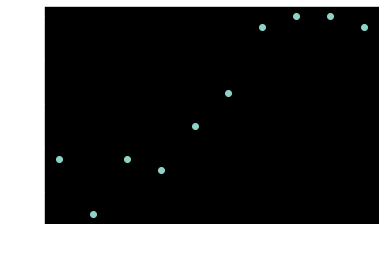

In [ ]:
# Probability data 
plt.figure()
plt.scatter(stimuli, p_correct)
plt.xlabel('Stimuli')
plt.ylabel('p(correct)')
plt.show()

# Fit a psychometric function 

In [ ]:
#@title Hand fit psychometric function 
def hand_min(Alpha, Beta, Gamma, Lambda):
  # INPUTS:
  # Alpha: midpoint 
  # Beta: slope
  # Gamma: guess rate
  # Lambda: lapse rate

  # OUTPUT:
  # figure showing relationship between parameters and function 


  # annoymous function to evalute curve 
  func = lambda x, signal: x[2] + (1 - x[2] - x[3]) * (1 / (1 + np.exp(-x[1]*(signal - x[0])))) # alpha, beta, gamma, lambda

  # plot 
  plt.figure()
  plt.scatter(stimuli, p_correct)
  x = np.arange(0, 10, step=0.01)
  plt.plot(x, func([Alpha, Beta, Gamma, Lambda], x), linewidth=2)
  plt.xlabel('Stimuli')
  plt.ylabel('p(correct)')
  plt.show()

In [ ]:
# Understand relationship between parameters and curve
w = widgets.interact(hand_min, Alpha = (0,10,0.5), Beta = (0,25,0.5), Gamma = (0,1,0.01), Lambda = (0,1,0.01));

interactive(children=(FloatSlider(value=5.0, description='Alpha', max=10.0, step=0.5), FloatSlider(value=12.0,…

In [ ]:
#@title negative log likelihood function 
def negloglik(Alpha, Beta, Gamma, Lambda, signal, trials, correct):
  # INPUTS:
  # Alpha: midpoint 
  # Beta: slope
  # Gamma: guess rate
  # Lambda: lapse rate
  # signal: stimuli signals (N X 1)
  # trials: total number of trials per signal (N X 1)
  # correct: number of correct trials per signal (N X 1)

  # OUTPUT:
  # nll: negative log likelihood 

  # sigmoid
  pcI = Gamma + (1 - Gamma - Lambda) * (1 / (1 + np.exp(-Beta*(signal - Alpha))))

  # negative log likelihood 
  nll = -sum(correct * np.log(pcI) + (trials - correct) * (np.log(1 - pcI)))

  return nll

In [ ]:
# reshape 
stimuli = np.reshape(stimuli, newshape=[10,1])

# write lambda (anonymous) function (thanks Hyosub)
NLL = lambda x: negloglik(x[0], x[1], x[2], x[3], stimuli, trials, correct)
# maximum likelihood estimation 
xopt = scipy.optimize.fmin(func=NLL, x0=np.array([5, 3, 0.25, 0]))
print(xopt)

Optimization terminated successfully.
         Current function value: 83.675319
         Iterations: 131
         Function evaluations: 222
[5.69235921 1.87397729 0.27316932 0.01584123]


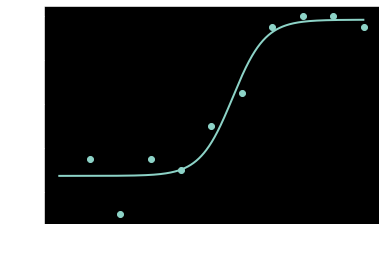

In [ ]:
# annoymous function to evalute curve 
func = lambda x, signal: x[2] + (1 - x[2] - x[3]) * (1 / (1 + np.exp(-x[1]*(signal - x[0])))) # alpha, beta, gamma, lambda

# Visualize 
plt.figure()
plt.scatter(stimuli, p_correct)
x = np.arange(0, 10, step=0.01)
plt.plot(x, func(xopt, x), linewidth=2)
plt.xlabel('Stimuli')
plt.ylabel('p(correct)')
plt.show()

# Non-Parametric Bootstrap

Double click $\textbf{here}$ for answer  

<!-- # pre-set
nboots=500 # number of iterations 
b_coeffs = np.zeros(shape=[nboots,4]) # empty array 

# simulate 
for i in np.arange(0,nboots):

  # empty array 
  sim_correct = np.zeros(shape=[10,1])

  for ii, v in enumerate(stimuli):

    # data 
    stim_resp = EXP[EXP['stimuli'] == v[0]][['stimuli', 'direction', 'response']]

    # Correct
    correct = stim_resp['direction'] == stim_resp['response']

    # resample with replacement
    sim_resp = np.random.choice(correct, size=np.shape(correct), replace=True)

    # number correct 
    sim_correct[ii] = sum(sim_resp)

  # fit curve 
  NLL = lambda x: negloglik(x[0], x[1], x[2], x[3], stimuli, trials, sim_correct)
  b_coeffs[i,:] = scipy.optimize.fmin(func=NLL, x0=np.array([5, 3, 0.25, 0])); -->

In [ ]:
# # pre-set
# nboots = # number of iterations 
# b_coeffs =  # empty array 

# # simulate 
# for i in np.arange(0,nboots):

#   # empty array 
#   sim_correct = np.zeros(shape=[10,1])

#   for ii, v in enumerate(stimuli):

#     # data 
#     stim_resp = 

#     # Correct
#     correct = 

#     # resample with replacement
#     sim_resp = 

#     # number correct 
#     sim_correct[ii] = 

#   # fit curve 
#   NLL = lambda x: negloglik(x[0], x[1], x[2], x[3], stimuli, trials, sim_correct)
#   b_coeffs[i,:] = scipy.optimize.fmin(func=NLL, x0=np.array([5, 3, 0.25, 0]));

In [ ]:
# # Visualize 
# plt.figure(figsize=(8,8))
# for i in range(4):
#   plt.subplot(2,2,i+1);
#   plt.hist(b_coeffs[:,i])
#   if i == 0:
#     plt.title('alpha')
#   elif i == 1:
#     plt.title('beta')
#   elif i == 2:
#     plt.title('gamma')
#   else:
#     plt.title('lambda')

# plt.suptitle('Non-parametric boostrap')
# plt.show()